# 1 - Importar libs e carregar os DataFrames

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from datetime import timedelta
import pickle
%matplotlib inline

# machine learning models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from yellowbrick.classifier import ROCAUC

# preprocessing and pipeline
from sklearn.preprocessing import (StandardScaler,  # REESCALANDO FEATURES
                                   MinMaxScaler, 
                                   RobustScaler, 
                                   LabelEncoder)
from sklearn.pipeline import Pipeline # CRIANDO PIPELINES
from sklearn import set_config
from imblearn.under_sampling import RandomUnderSampler

# import category_encoders as ce

# # feature selection
# from sklearn.feature_selection import SelectKBest, chi2, RFE  # SELEÇÃO DE FEATURES


# mode selection and metrics
from sklearn.model_selection import (train_test_split,  # METRICAS
                                     GridSearchCV,
                                     KFold,
                                     StratifiedKFold,
                                     RandomizedSearchCV,
                                     cross_val_score)

from sklearn import metrics

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             precision_score, 
                             recall_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve
                            )

# warnings option
import warnings
warnings.filterwarnings('ignore')

# 2 - Lendo Arquivos

In [4]:
df = pd.read_pickle('dados/cleaned/df_preped.pkl')
df_idh = pd.read_pickle('dados/cleaned/df_idh.pkl')
df_populacao = pd.read_excel('dados/cleaned/pop_saopaulo.xlsx')

In [5]:
features = ['cardiopatia','diabetes', 'doenca_neurologica', 'obesidade', 'outros_fatores_de_risco','idade', 'cs_sexo']

# Criando matriz X de variaveis explicativas
X = df[features]

# Criando a variavel target
y = df.obito

In [6]:
X.shape,y.shape

((4361064, 7), (4361064,))

# 3 - Balanceamento dos dados

O desbalancemanto dos dados para treinar o modelo pode inserir viés na análise, por isso o modelo será treinado com dados balanceados

In [7]:
df['obito'].value_counts()

0    4208562
1     152502
Name: obito, dtype: int64

<AxesSubplot:ylabel='obito'>

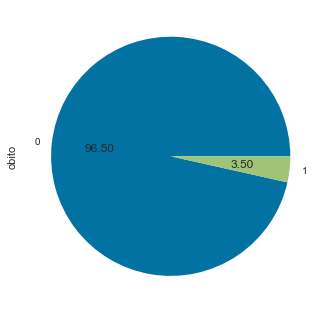

In [8]:
df['obito'].value_counts().plot.pie(autopct='%.2f')

In [9]:
# Instanciando o NearMIss
under_sampler = RandomUnderSampler(sampling_strategy=1) # FLOAT

In [10]:
# Aplicando o NearMiss nos dados para igualar a quantidade de amostras das classes
X_res, y_res = under_sampler.fit_resample(X, y)

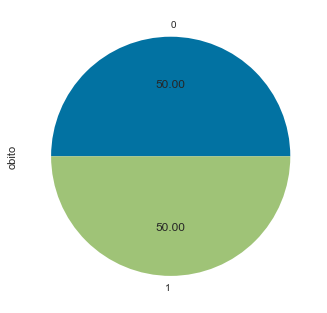

In [11]:
ax = y_res.value_counts().plot.pie(autopct='%.2f')

In [12]:
y_res.value_counts()

0    152502
1    152502
Name: obito, dtype: int64

# 4 - Modelagem

Utilizando oa função tools.add_constant() do pacote statsmodel adicionaremos uma coluna contendo apenas '1' na matriz X que servir como entidade de coeficiante de intepretação do modelo

In [13]:
X_res = sm.tools.add_constant(X_res)

In [14]:
X_res.head(4)

,const,cardiopatia,diabetes,doenca_neurologica,obesidade,outros_fatores_de_risco,idade,cs_sexo
0,1.0,0,0,0,0,0,48.0,0
1,1.0,0,0,0,0,0,29.0,1
2,1.0,0,0,0,0,0,53.0,1
3,1.0,0,0,0,0,0,30.0,1


## 4.1 - Dividindo entre Treino e Teste

In [15]:
seed = 123
size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size = size, random_state = seed)

In [16]:
print('Treino: ',X_train.shape, y_train.shape , '\nTeste: ', X_test.shape, y_test.shape) #

Treino:  (213502, 8) (213502,) 
Teste:  (91502, 8) (91502,)


## 4.2 - Regressão Logistitca

In [17]:
# Vamos instanciar o modelo e dar um Fit ()
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.379914
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  obito   No. Observations:               213502
Model:                          Logit   Df Residuals:                   213494
Method:                           MLE   Df Model:                            7
Date:                Mon, 07 Mar 2022   Pseudo R-squ.:                  0.4519
Time:                        20:54:11   Log-Likelihood:                -81112.
converged:                       True   LL-Null:                   -1.4799e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.4079      0.023   -188.673      0.000      -4.454   

De modo a facilitar a interpretacao dos resultados, os dados serao gerados em termos percentuais relativos, esse percentual se aproxima da interpretação de um modelo de regressão linear

In [18]:
lista_coef = [2.5594 ,  1.2644 ,  2.5078 , 2.0562 , 1.9416 ,-0.5746 ,0.0732 ]
for elemento in lista_coef:
    print(round((np.exp(elemento) - 1) * 100,2))

1192.81
254.1
1127.79
681.62
596.99
-43.71
7.59


- Para cada ano a mais de idade, as chances de morte aumentam diminuem 7%.
-  Para pessoas com problemas de cardiopatia tem 115% mais chances de obito. 
-  Para pessoas com problemas de diabetes tem 84% mais chances de obito. 
-  Para pessoas com problemas de obesiade tem 625% mais chances de obito. 
-  Para pessoas com problemas de outros fatores de risco tem 481% mais chances de obito. 
-  Para pessoas com problemas de pneumopatia tem 239% mais chances de obito. 

In [19]:
#### Usando Sklearn
# Criando matriz X sem a constante
X1 = X_res.drop('const', axis=1)
X1_train = X_train.drop('const',axis=1)
X1_test = X_test.drop('const',axis=1)

# Criando a variavel target continua sendo Y_res


In [20]:
model = LogisticRegression(fit_intercept=True, penalty='l2', C = 1e10,)
model.fit(X1_train,y_train)

LogisticRegression(C=10000000000.0)

In [21]:
model.intercept_,model.coef_

(array([-4.40790935]),
 array([[ 0.90788847,  0.84319327,  1.84575161,  2.97110847,  2.2969842 ,
          0.07475077, -0.60712939]]))

Faremos a previsao y_pred dos nossos targets usando a função .predict() aplicada aos dados de treino X_test

In [22]:
y_pred = model.predict(X1_test)
y_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [24]:
y_test.value_counts()

1    45842
0    45660
Name: obito, dtype: int64

## 4.2.1 - Matriz de confusao

<AxesSubplot:>

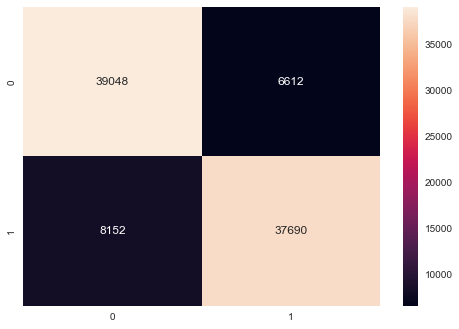

In [25]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd')

In [26]:
acuracia = accuracy_score(y_test,y_pred)
display(acuracia)

0.838648335555507

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     45660
           1       0.85      0.82      0.84     45842

    accuracy                           0.84     91502
   macro avg       0.84      0.84      0.84     91502
weighted avg       0.84      0.84      0.84     91502



## 4.3 - Curva Roc

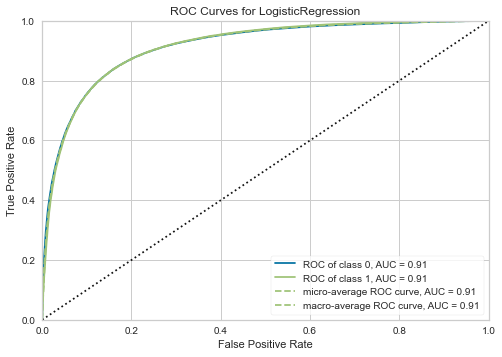

In [28]:
visualizer = ROCAUC(model, classes = [0, 1])

visualizer.fit(X1_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X1_test, y_test)        # Evaluate the model on the test data
visualizer.show();  

## 4.4 - KNN 

In [29]:
knn = KNeighborsClassifier(n_neighbors= 5)

knn.fit(X1_train,
       y_train
       )
y_pred = knn.predict(X1_test)

<AxesSubplot:>

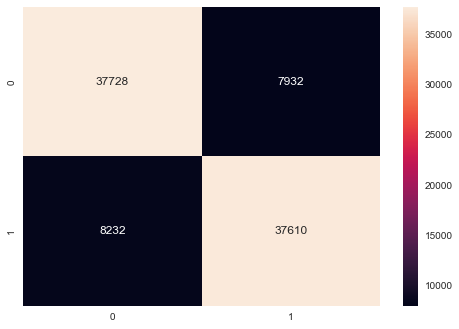

In [30]:
# Aplicando o KNN nos dados de teste.
y_pred = knn.predict(X1_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# plotando a matriz de confusao
sns.heatmap(cnf_matrix, annot = True, fmt = 'd')


In [31]:
# Imprimindo as métricas
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.83      0.82     45660
     class 1       0.83      0.82      0.82     45842

    accuracy                           0.82     91502
   macro avg       0.82      0.82      0.82     91502
weighted avg       0.82      0.82      0.82     91502



## 4.5 - SVC

In [34]:
svc_clf = SVC()

svc_clf.fit(X1_train, y_train)

SVC()

In [35]:
y_pred = svc_clf.predict(X1_test)

In [38]:
pickle.dump(svc_clf, open('models/svc_clf.pkl', 'wb'))

In [32]:
pickle.load(open('models/svc_clf.pkl', 'rb'))

SVC()

In [39]:
# acurácia
accuracy = accuracy_score(y_test, y_pred)

# recall
recall = recall_score(y_test, y_pred)

# precision
precision = precision_score(y_test, y_pred)

# mostra as métricas do modelo
print(f'Accurácia: {round(accuracy, 3)}')
print(f'Recall: {round(recall, 3)}')
print(f'Precision: {round(recall, 3)}')

Accurácia: 0.838
Recall: 0.832
Precision: 0.832


## 4.6 - Outros Classificadores

Rodando outros classificadores de Machine Learning
Os resultados não são satisfatórios. Uma coisa que podemos fazer é resolver esse problema tentar alguns modelos, testar no nosso dataset e optear pelo que se sai melhor.

In [40]:
classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter = 5_000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    SVC()
]

In [ ]:
# criando um dataframe em branco
modelos = pd.DataFrame()

for clf in classifiers:

    clf.fit(X1_train, y_train)
    # armazenando o nome do modelo na variável name
    name = clf.__class__.__name__
    # adicionando os resultados do modelo em um dataframe
    y_pred = clf.predict(X1_test)

    # salvar os modelos treinados para nao precisar treinar novamente
    pickle.dump(clf, open(f'models/{name}.pkl', 'wb'))

    # dicionario com os valores
    dict = {'Method': name,
     'Accuracy': metrics.accuracy_score(y_test, y_pred),
     'Precision': metrics.precision_score(y_test,y_pred),
     'Recall' : metrics.recall_score(y_test,y_pred)
          }
    # append dos dados no dataframe
    modelos = df.append(dict, ignore_index = True)

modelos

In [43]:
df

,Method,Accuracy,Precision,Recall
0,KNeighborsClassifier,0.822146,0.827311,0.815148
1,GaussianNB,0.797010,0.890771,0.677959
2,LogisticRegression,0.838747,0.853430,0.818747
3,DecisionTreeClassifier,0.840320,0.837800,0.844837
4,RandomForestClassifier,0.840473,0.837937,0.845011
5,GradientBoostingClassifier,0.841687,0.840782,0.843790


Comparando os modelos observamos que SVC tem resultados muito semelhantes aos demais e consome muito mais tempo de processamento e por isso nao terá seus parametros otimizacos.

# 5 - Avaliação de Modelos

Vamos encontrar os melhores hiperparâmetros para os modelos acima no problema. 

Utilizaremos a **validação cruzada** para generalizar o modelo, o metodo consiste em dividir em porções de treino e teste, esses dados são embaralhados e divididos em k números de dobras (folds), assim a cada interação temos um conjunto diferente de dados para treino e teste. Assim é criado um modelo que será treinado e o resultado passa a ser uma media dos valores de cada grupo.

Importante notar que o modelo Naive Bayes não tem hiperparâmetro e, portanto, não precisa ser otimizado.

In [65]:
# quantidade de folds da validação cruzada
folds = 5
# random state
SEED = 20
# critério de avaliação
scoring = 'accuracy'

# modelos com valores default
models = [
    ('LR',   LogisticRegression(max_iter = 5_000)),
    ('CART', DecisionTreeClassifier()),
    ('KNN',  KNeighborsClassifier(n_neighbors=5)),
    ('RFC',  RandomForestClassifier()),
    ('GBC',  GradientBoostingClassifier())
]

# validação cruzada
resultados = []
nome_modelo = []

for type_modelo, modelo in models:
    # função para validar a validação cruzada
    stratified_fold = StratifiedKFold(n_splits = folds, shuffle = True, random_state = SEED)
    # validação cruzada
    cv_result = cross_val_score(
        estimator = modelo,    # modelo
        X = X_res,             # variáveis explicativas 
        y = y_res,             # target
        cv = stratified_fold,  # função kfold 
        scoring = scoring      # critério de avaliação, neste caso acurácia  
    )
    # armazena os resultados na lista cv_result
    resultados.append(cv_result)
    # armazena os resultados na lista type_modelo
    nome_modelo.append(type_modelo)

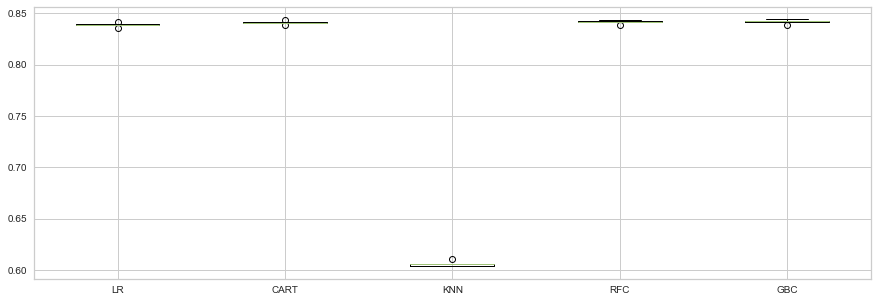

In [80]:
# resultados da validação cruzada
fig, ax = plt.subplots(figsize = (15, 5))
ax.boxplot(resultados)
ax.set_xticklabels(nome_modelo)
fig.savefig('figs/cross_validation.png')

removendo o knn porque está distorcendo a visualizacao


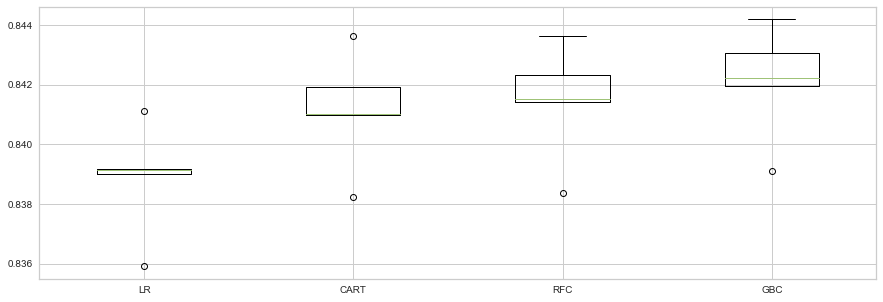

In [81]:

# resultados da validação cruzada
fig, ax = plt.subplots(figsize = (15, 5))
ax.boxplot(resultados[0:2] + resultados [3:5])
ax.set_xticklabels(nome_modelo[0:2] + nome_modelo [3:5])
fig.savefig('figs/cross_validation1.png')

olhando os limites do boxplot escolheu o CART

# 6 - Otimização de Modelos

## 6.3 - Decision Tree (CART)

In [82]:
# critério a ser utilizado
criterion = 'entropy'
# range de profundidade para a árvore
max_depths_range = np.arange(1, 41)
# listas para armazenar informações durante o loop
# resultados com dados de treino
train_results = []
# resultados com dados de teste
test_results = []

# itera no range de profundidades e para cada profundidade treina um CART
for max_depth in max_depths_range:
    # treina o modelo
    cart_model = DecisionTreeClassifier(max_depth = max_depth, 
                                        criterion = criterion)
    
    cart_model.fit(X1_train, y_train)
    # previsão com dados de treino
    train_pred = cart_model.predict(X1_train)
    # acurácia
    accuracy_train = accuracy_score(y_train, train_pred)
    
    # teste
    y_pred = cart_model.predict(X1_test)
    # acurácia 
    accuracy_test = accuracy_score(y_test, y_pred)
    
    train_results.append(accuracy_train)
    test_results.append(accuracy_test)

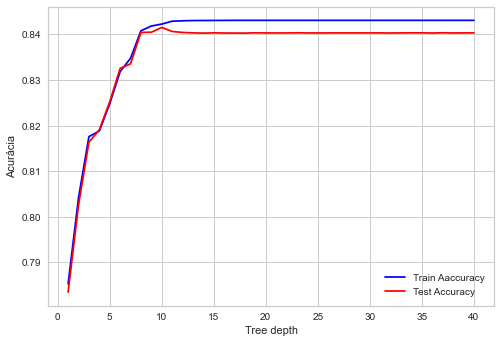

In [83]:
# plot dos dados de treino
plt.plot(max_depths_range, train_results, color = 'blue', label = 'Train Aaccuracy')
# plot dos dados de teste
plt.plot(max_depths_range, test_results, color = 'red', label = 'Test Accuracy')
# legenda
plt.legend()
# rótulo da figura
plt.ylabel('Acurácia')
plt.xlabel('Tree depth')
plt.show()
fig.savefig('figs/tree_depth_accuracia.png')

In [84]:
# dicionários com os hiperparâmetros do modelo CART
param_grid_cart = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 15),
    'min_samples_leaf' : np.arange(1,5),
    'min_samples_split': np.arange(1,10),
}

cart_model = DecisionTreeClassifier()

### 6.3.1 - Grid Search

In [85]:
# aplica o GridSearch para o modelo CART
grid_cart = GridSearchCV(
    estimator = cart_model,
    param_grid = param_grid_cart,
    scoring = scoring,
    cv = stratified_fold,
    n_jobs = -1
)

In [86]:
grid_cart_result = grid_cart.fit(X_res, y_res)

dump model

In [96]:
# salvar os modelos treinados para nao precisar treinar novamente
pickle.dump(clf, open('models/grid_cart_result.pkl', 'wb'))

In [88]:
# melhores parâmetros obtidos
grid_cart_result.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

*Printar a arvore*

In [89]:
# critério
grid_cart_result.best_estimator_.criterion

'entropy'

In [90]:
# profundidade
grid_cart_result.best_estimator_.max_depth

9

In [91]:
# best score
grid_cart_result.best_score_

0.8419037145050833

### 6.3.2 - Randomized Search

In [92]:
# random search
# cv: For integer/None inputs, if the estimator is a classifier and ``y`` is
#     either binary or multiclass, :class:`StratifiedKFold` is used. In all
#     other cases, :class:`KFold` is used.

random_search = RandomizedSearchCV(cart_model, 
                                   param_grid_cart, 
                                   cv = stratified_fold, 
                                   scoring = scoring,
                                   random_state = SEED,
                                   n_iter = 10
                                  )

In [93]:
random_search.fit(X_res, y_res)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=20, scoring='accuracy')

In [94]:
random_search.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [95]:
random_search.best_score_

0.8416709301459987

In [ ]:
##

In [ ]:
# melhores parâmetros obtidos
grid_cart_result.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [98]:
random_search.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'entropy'}

In [100]:
# quantidade de folds da validação cruzada
folds = 5
# random state
SEED = 20
# critério de avaliação
scoring = 'accuracy'

# modelos com valores default
models = [
    ('CART_grid', DecisionTreeClassifier(criterion= 'entropy', max_depth=9, min_samples_leaf=1, min_samples_split=4)),
    ('CART_search', DecisionTreeClassifier(criterion= 'entropy', max_depth=10,min_samples_leaf=2, min_samples_split=7))
]

# validação cruzada
resultados = []
nome_modelo = []

for type_modelo, modelo in models:
    # função para validar a validação cruzada
    stratified_fold = StratifiedKFold(n_splits = folds, shuffle = True, random_state = SEED)
    # validação cruzada
    cv_result = cross_val_score(
        estimator = modelo,    # modelo
        X = X,                 # variáveis explicativas 
        y = y,                 # target
        cv = stratified_fold,  # função kfold 
        scoring = scoring      # critério de avaliação, neste caso acurácia  
    )
    # armazena os resultados na lista cv_result
    resultados.append(cv_result)
    # armazena os resultados na lista type_modelo
    nome_modelo.append(type_modelo)

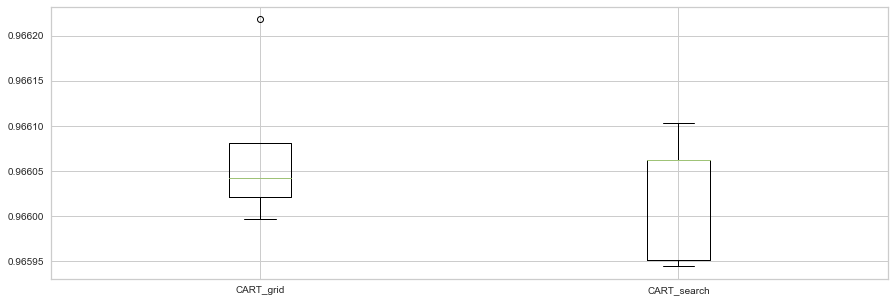

In [101]:

# resultados da validação cruzada
fig, ax = plt.subplots(figsize = (15, 5))
ax.boxplot(resultados)
ax.set_xticklabels(nome_modelo)
fig.savefig('figs/cross_validation2.png')

In [54]:
cart_tuned = DecisionTreeClassifier(criterion= 'entropy', max_depth=9, min_samples_leaf=1, min_samples_split=4)

In [55]:
 cart_tuned.fit(X1_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=4)

In [56]:
# armazenando o nome do modelo na variável name
y_pred = cart_tuned.predict(X1_test)

In [57]:
print (f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print (f'Precision: {metrics.precision_score(y_test, y_pred)}')
print (f'Recall: {metrics.recall_score(y_test, y_pred)}')

Accuracy: 0.84134773010426
Precision: 0.843664289632474
Recall: 0.8387504908162821



DecisionTreeClassifier	0.840320	0.837800	0.844837

In [59]:
# salvar os modelos treinados para nao precisar treinar novamente
pickle.dump(cart_tuned, open(f'models/clf_tuned.pkl', 'wb'))

In [60]:
cart_tuned.predict([])

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=4)

In [ ]:
# ['cardiopatia','diabetes', 'doenca_neurologica', 'obesidade', 'outros_fatores_de_risco','idade', 'cs_sexo']

In [62]:
# Previsão de test
pred_test = model.predict([[0,0,0,0,0,59,0]])
pred_test

array([1], dtype=int64)